#### Import required layers and utils from the framework

In [1]:
import keras

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator

from keras import callbacks
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, merge, Input, Lambda, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras import backend as K


# from theano.sandbox.cuda.dnn import *

Using TensorFlow backend.


#### Import other required utils

In [2]:
from copy import deepcopy
import datetime
import dicom
from fnmatch import fnmatch
import h5py
import numpy as np
import os
from os import path, walk
import pandas as pd
import pickle
from PIL import Image, ImageDraw
import re
import time
from matplotlib import pyplot as plt
from scipy.misc.pilutil import imresize

%matplotlib inline
plt.set_cmap('gray')

#### sci-kit learn stuff

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [108]:
get_available_gpus()

['/gpu:0']

In [85]:
DICOM_PREFIX = "/data/analytics/xray_cm/images/"
MASK_PREFIX  = "/home/analytics/projects/xray_cardiometry/data/masks/"

BATCH_SIZE = 5
EPOCH_NUM = 300

X_IMAGE_SIZE = 1024
IMAGE_SIZE = 1024

STRUCTURE = "lung"
EXPERIMENT_NAME = "%s_segmentation_indiana" % STRUCTURE
OUT_DIR = "/data/analytics/xray_cm/models/%s" % EXPERIMENT_NAME
DO_LRN = True # LRN is Local Response Normalization (lateral inhibition)

MODEL_FILENAME = "%s_u-net_%s" % (EXPERIMENT_NAME, datetime.date.today().strftime("%d%b%Y"))

In [ ]:
images = []
masks = []
cases = []

for case in ["atherosclerosis", "calcinosis", "cardiomegaly_mild", "cardiomegaly_modsev", "normal", "tortuous_aorta"]:

    filenames = !ls "$MASK_PREFIX"/"$case"_masks/ | grep ".png$"
    
    max_iter = len(filenames)
    print("case: " + case)
    for counter, mask_filename in enumerate(filenames):
        print("\r", "%.2f" % (counter / max_iter * 100) + "%", end="")
        
        image_filename = os.path.join(DICOM_PREFIX, mask_filename)
        image = imresize(plt.imread(image_filename), [IMAGE_SIZE, IMAGE_SIZE])
        mask_filename = os.path.join(MASK_PREFIX, case + "_masks", mask_filename)
        mask = (imresize(plt.imread(mask_filename).mean(axis=2), [IMAGE_SIZE, IMAGE_SIZE]) > 0.5).astype(int)
        
        images.append(image)
        masks.append(mask)
        cases.append(case)
    print()

In [ ]:
images = np.array(images)
masks = np.array(masks)
cases = np.array(cases)

In [ ]:
np.savez_compressed("../pickles/segmentation_data_1024", images=images, masks=masks, cases=cases)

In [25]:
data_file = np.load("../pickles/segmentation_data.npz")
images = data_file["images"]
masks = data_file["masks"]
cases = data_file["cases"]

In [69]:
data_file = np.load("../pickles/segmentation_data_1024.npz")
images = data_file["images"]
masks = data_file["masks"]
cases = data_file["cases"]

#### This version of U-net uses zero-padding so as to leave image size unchanged

In [70]:
smooth = 1.

In [86]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_np(y_true,y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [87]:
def get_unet():
    inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 1))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPool2D(pool_size=(2, 2))(conv5)
    
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool5)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv5], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv4], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv3], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    
    up10 = concatenate([UpSampling2D(size=(2, 2))(conv9), conv2], axis=3)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    
    up11 = concatenate([UpSampling2D(size=(2, 2))(conv10), conv1], axis=3)
    conv11 = Conv2D(16, (3, 3), activation='relu', padding='same')(up11)
    conv11 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv11)

    conv12 = Conv2D(1, (1, 1), activation='sigmoid')(conv11)

    model = Model(inputs=inputs, outputs=conv12)

    model.compile(optimizer="adam", loss="binary_crossentropy")

    return model

In [88]:
model = get_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
train_indices, validate_indices = train_test_split(range(len(images)))
np.savez_compressed("../pickles/train_test_sep.npz", train_indices=train_indices, validate_indices=validate_indices)

In [80]:
X = images[:, :, :, :3].mean(axis=3, keepdims=True) / 255
Y = masks[:, :, :, None]
# Y = pd.get_dummies(cases).values

In [81]:
print(X.shape, Y.shape)
print(X.max(), Y.max())

(329, 1024, 1024, 1) (329, 1024, 1024, 1)
1.0 1


In [14]:
train_test_file = np.load("../pickles/train_test_sep.npz")
train_indices = train_test_file["train_indices"]
validate_indices = train_test_file["validate_indices"]

In [82]:
X_train, X_validate = X[train_indices], X[validate_indices]
Y_train, Y_validate = Y[train_indices], Y[validate_indices]

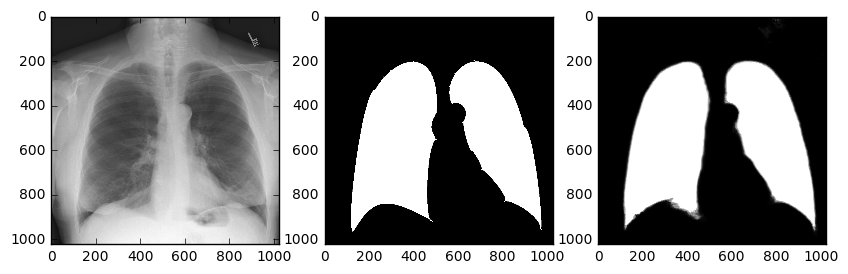

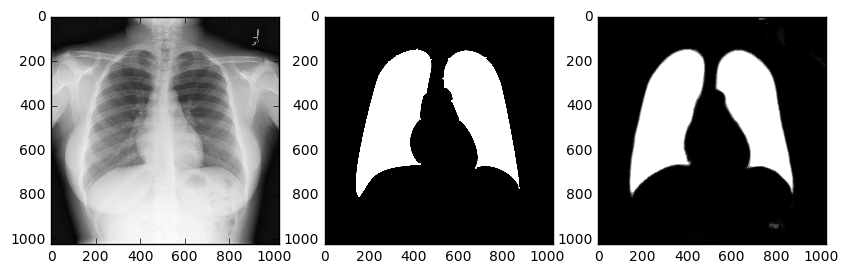

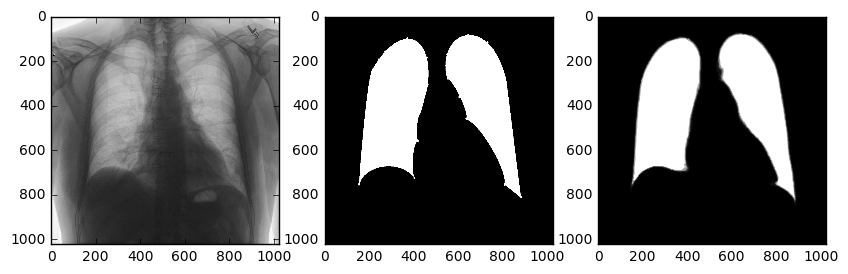

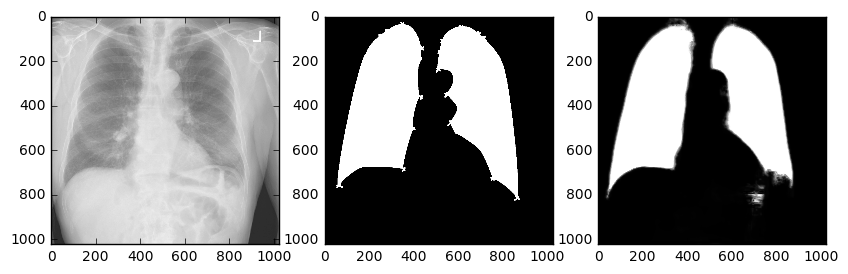

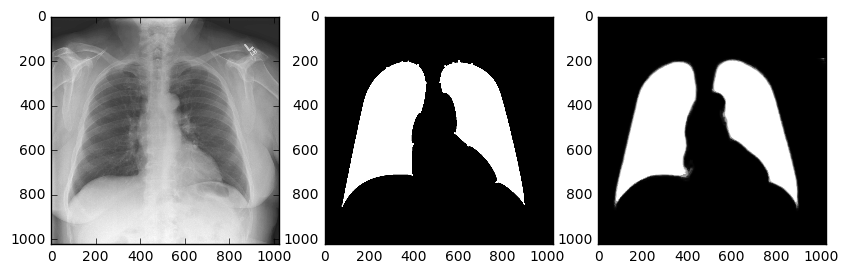

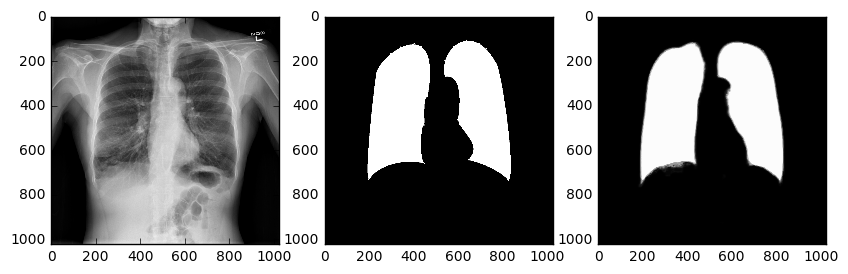

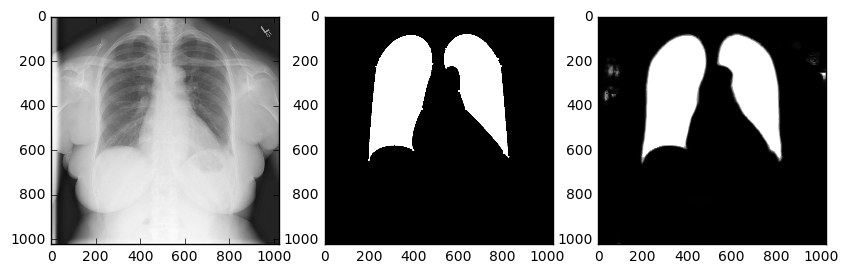

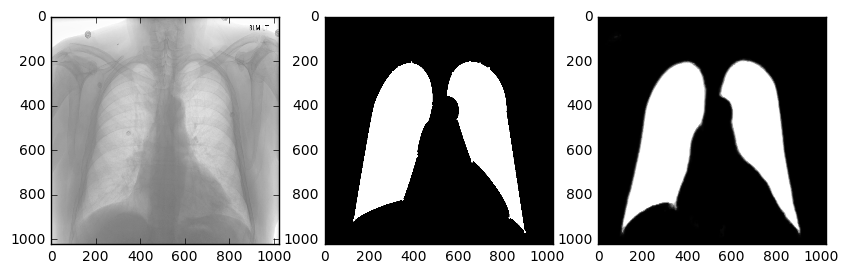

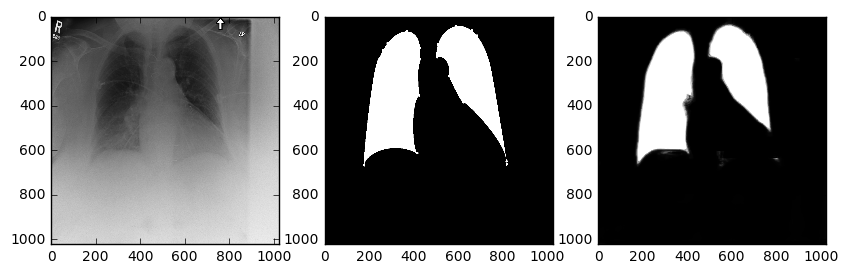

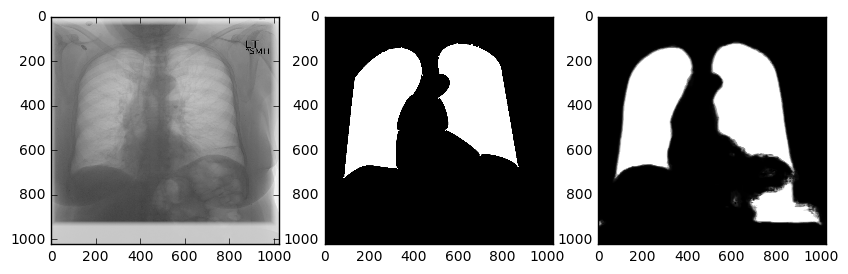

In [92]:
for i in range(10, 20):
    plt.figure(i, figsize=(10, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(X_validate[i, :, :, 0])
    plt.subplot(1, 3, 2)
    plt.imshow(Y_validate[i, :, :, 0])
    plt.subplot(1, 3, 3)
    plt.imshow(model.predict(np.array(X_validate[i : i+1]))[0, :, :, 0])

In [ ]:
datagen = ImageDataGenerator(
                    featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=10.,
                    zoom_range=0.1,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    fill_mode='constant',
                    cval=0.,
                    horizontal_flip=True)

for ep in range(300):
    e = ep + 0
    print('Epoch', e)
    batches = 0

    epoch_finished = False
    start = time.time()

    print("\r", "0%", end="")
    max_iter = X_train.shape[0] // BATCH_SIZE + (X_train.shape[0] % BATCH_SIZE != 0)
    train_losses = np.zeros((max_iter, 2))
    
    for i, X_batch in enumerate(datagen.flow(np.concatenate([X_train, Y_train, np.zeros_like(X_train)], axis=3), 
                                batch_size=BATCH_SIZE)):

        print("\r", "%.2f" % (i / max_iter * 100) + "%", end="")
        Y_batch = np.expand_dims(X_batch[:, :, :, 1], 3)
        X_batch = np.expand_dims(X_batch[:, :, :, 0], 3)

        loss = model.train_on_batch(X_batch, Y_batch)
        train_losses[i, :] = loss
        batches += 1
        if batches >= len(X_train) / BATCH_SIZE:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            validation_loss = model.evaluate(X_validate, Y_validate, verbose=0, batch_size=BATCH_SIZE)
            print('train loss: ', np.mean(train_losses, axis=0), 
                  'validation loss: ', validation_loss)
            break
                
    model.save_weights("../models/" + MODEL_FILENAME + '_' + str(e) + '.h5', overwrite=True)
    print('Time per epoch: ', time.time() - start)

Epoch 0
 98.00%train loss:  [ 0.52676977  0.76063194] validation loss:  [0.56922807499586814, 0.76289133494158823]
Time per epoch:  144.99540066719055
Epoch 1
 98.00%train loss:  [ 0.41895385  0.76348013] validation loss:  [0.4608041410704693, 0.76289141034505459]
Time per epoch:  141.690092086792
Epoch 2
 98.00%train loss:  [ 0.41679888  0.76164965] validation loss:  [0.44372043911233006, 0.7628912904176367]
Time per epoch:  142.06378364562988
Epoch 3
 98.00%train loss:  [ 0.39992696  0.76412206] validation loss:  [0.41862067508410261, 0.76289133206907522]
Time per epoch:  142.0396375656128
Epoch 4
 98.00%train loss:  [ 0.38581386  0.76520024] validation loss:  [0.41471494034112216, 0.762891207832888]
Time per epoch:  143.38865613937378
Epoch 5
 98.00%train loss:  [ 0.39532547  0.76282489] validation loss:  [0.49892977131418437, 0.76185646042766342]
Time per epoch:  144.34245610237122
Epoch 6
 98.00%train loss:  [ 0.39037838  0.76975975] validation loss:  [0.42383344704846304, 0.77367

KeyboardInterrupt: 

In [101]:
whole_data_file = np.load("../pickles/data.npz")
whole_X = whole_data_file["X"] / 255.

In [95]:
orientations = np.load("../pickles/orientations.npz")["predicted"]

In [104]:
whole_segmented[1].shape

(1024, 1024, 1)

In [109]:
whole_segmented = model.predict(whole_X[orientations == '1', :, :, None], batch_size=5)

In [ ]:
np.savez_compressed("../pickles/segmented.npz", frontal=whole_segmented)